In [0]:
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### DGR Models

In [0]:
class Generator_Conv(torch.nn.Module):
    """
    Generator Class for GAN
    """
    def __init__(self, input_node_size, output_shape, hidden_node_size=256,
                    hidden_node_num=3):
        """
        input_node_size: dimension of latent vector
        output_shape: dimension of output image
        """
        super(Generator_Conv, self).__init__()

        self.input_node_size = input_node_size
        self.output_shape = output_shape
        num_channels, width, _ = output_shape

        layer_channels = []
#         if width <= 32:
        layer_channels.append(width//2)
        layer_channels.append(width//4)

        conv2d_1 = torch.nn.ConvTranspose2d(in_channels=input_node_size,
                                   out_channels=width*4, 
                                   kernel_size=layer_channels[1], 
                                   stride=1,
                                   padding=0,
                                   bias=False)
        conv2d_2 = torch.nn.ConvTranspose2d(in_channels=width*4, 
                                   out_channels=width*2, 
                                   kernel_size=4, 
                                   stride=2,
                                   padding=1,
                                   bias=False)
        conv2d_3 = torch.nn.ConvTranspose2d(in_channels=width*2, 
                                   out_channels=num_channels, 
                                   kernel_size=4, 
                                   stride=2,
                                   padding=1,
                                   bias=False)

        self.network = torch.nn.Sequential(
            conv2d_1,
            torch.nn.BatchNorm2d(num_features = width*4),
            torch.nn.ReLU(inplace=True),
            conv2d_2,
            torch.nn.BatchNorm2d(num_features = width*2),
            torch.nn.ReLU(inplace=True),
            conv2d_3,
            torch.nn.Tanh()
        )

    def forward(self, x):
        _x = x.view(-1, self.input_node_size, 1, 1)
        return self.network(_x)
    
    
class Discriminator_Conv(torch.nn.Module):
    """
    Discriminator Class for GAN
    """
    def __init__(self, input_shape, hidden_node_size=256, output_node_size=1):
        """
        Parameters
        ----------
        input_shape: (C, W, H)

        """
        super(Discriminator_Conv, self).__init__()
        num_channels, width, _ = input_shape

        conv2d_1 = torch.nn.Conv2d(in_channels=num_channels, 
                                   out_channels=width*2, 
                                   kernel_size=4, 
                                   stride=2,
                                   padding=1,
                                   bias=False)
        conv2d_2 = torch.nn.Conv2d(in_channels=width*2, 
                                   out_channels=width*4, 
                                   kernel_size=4, 
                                   stride=2,
                                   padding=1,
                                   bias=False)
        conv2d_3 = torch.nn.Conv2d(in_channels=width*4, 
                                   out_channels=output_node_size, 
                                   kernel_size=7, 
                                   stride=1,
                                   padding=0,
                                   bias=False)

        self.network = torch.nn.Sequential(
            conv2d_1,
            torch.nn.BatchNorm2d(num_features=width*2),
            torch.nn.LeakyReLU(inplace=True),
            conv2d_2,
            torch.nn.BatchNorm2d(num_features=width*4),
            torch.nn.LeakyReLU(inplace=True),
            conv2d_3,
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x).view(-1, 1)

    
class Solver(torch.nn.Module):
    """
    Solver Class for Deep Generative Replay
    """
    def __init__(self, input_data_shape, T_n):
        assert len(input_data_shape) == 3

        super(Solver, self).__init__()
        num_channels, width, height = input_data_shape
        fc1 = torch.nn.Linear(num_channels*width*height, 128)
        fc2 = torch.nn.Linear(128, 256)
        fc3 = torch.nn.Linear(256, T_n)
        self.network = torch.nn.Sequential(
            fc1,
            torch.nn.ReLU(),
            fc2,
            torch.nn.ReLU(),
            fc3
        )

    def forward(self, x):
        return self.network(x.view(x.shape[0], -1))


### Set Hyperparameters

In [0]:
data_shape = (1, 128, 128)
num_noise = batch_size = 64
epochs = 200
ld = 10
tasks = 12

on_colab = True
divide_tasks = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

category={0: 'boxingmoving', 
          1: 'boxingstill', 
          2: 'crawling', 
          3: 'running', 
          4: 'still', 
          5: 'walking', 
          6: 'walkinglow'}

dt = datetime.datetime.now()

### Load Data

In [11]:
train_data = []
test_data = []

for task in range(1, tasks+1):
    if on_colab:
        data_path = 'drive/My Drive/projects/data/RADAR/Subject%d'%(task)
    else:
        data_path = './data/RADAR/Subject%d'%(task)

    train_data_per_task = []
    test_data_per_task = []
    for _, cat in category.items():
        # train data
        train_data_per_cat = []
        test_data_per_cat = []

        for i in range(1, 10):
            filename = 'Human_Spect_test%d_%s_0%d.png'%(task, cat, i)
            file_path = os.path.join(data_path, 'train', cat, filename)
            img = Image.open(file_path)
            img.load()
            img = np.array(img)
            train_data_per_cat.append(img)

        # test data
        for i in range(10, 13):
            filename = 'Human_Spect_test%d_%s_%d.png'%(task, cat, i)
            file_path = os.path.join(data_path, 'test', cat, filename)
            img = Image.open(file_path)
            img.load()
            img = np.array(img)
            test_data_per_cat.append(img)

        
        train_data_per_task.append(train_data_per_cat)
        test_data_per_task.append(test_data_per_cat)
        
    train_data.append(train_data_per_task)
    test_data.append(test_data_per_task)
    

train_data = torch.Tensor(train_data).to(device)
test_data = torch.Tensor(test_data).to(device)

print(train_data.shape)
print(test_data.shape)

train_labels = np.zeros((9, ))
test_labels = np.zeros((3, ))

for i in range(1, 7):
    train_labels = np.vstack((train_labels, np.zeros((9, )) + i))
    test_labels = np.vstack((test_labels, np.zeros((3, )) + i))

train_labels = torch.Tensor(train_labels).type(torch.LongTensor).to(device)
test_labels = torch.Tensor(test_labels).type(torch.LongTensor).to(device)

print(train_labels.shape)
print(test_labels.shape)

torch.Size([12, 7, 9, 128, 128])
torch.Size([12, 7, 3, 128, 128])
torch.Size([7, 9])
torch.Size([7, 3])


### Library

In [0]:
def sample_noise(batch_size, N_noise, device='cpu'):
    """
    Returns 
    """
    if torch.cuda.is_available() and device == 'cpu':
        device='cuda:0'
    
    return torch.randn(batch_size, N_noise).to(device)


def init_params(model):
    """
    initiallize network's parameter
    """
    for p in model.parameters():
        if(p.dim() > 1):
            torch.nn.init.xavier_normal_(p)
        else:
            torch.nn.init.uniform_(p, 0.1, 0.2)
            
            
def tensor_normalize(tensor):
    """
    Normalize tensor to [-1, 1]
    """
    _tensor = tensor.detach().clone()
    _tensor_each_sum = _tensor.sum(dim=1)
    _tensor /= _tensor_each_sum.unsqueeze(1)

    _tensor[torch.isnan(_tensor)] = 0.0
    _tensor = 2*_tensor - 1
    return _tensor


def model_grad_switch(net, requires_grad):
    """
    switch network's requires_grad
    """
    for params in net.parameters():
        params.requires_grad_(requires_grad)

### Training & Validate

In [0]:
train_data = tensor_normalize(train_data)
train_labels = tensor_normalize(train_labels)
test_data = tensor_normalize(test_data)
test_labels = tensor_normalize(test_labels)

gen = Generator_Conv(input_node_size=num_noise, output_shape=data_shape).to(device)
disc = Discriminator_Conv(input_shape=data_shape).to(device)

init_params(gen)
init_params(disc)

optim_g = torch.optim.Adam(gen.parameters(), lr=1e-3, betas=(0, 0.9))
optim_d = torch.optim.Adam(disc.parameters(), lr=1e-3, betas=(0, 0.9))

#logfile_name = "logfile_training_%d_%d_%d_%d_%d.txt" % (dt.year, dt.month, dt.day, dt.hour, dt.minute)
#log_file = open(logfile_name, "w")

for epoch in range(epochs):
    gen.train()
    disc.train()

    for i in range(10):
        for _train_data in train_data:
            x = _train_data.view(-1, 1, 128, 128).to(device)
            num_data = x.shape[0]
            noise = sample_noise(num_data, num_noise).to(device)

            x_g = gen(noise)

            ### Discriminator train
            optim_d.zero_grad()

            ## Regularization Term
            eps = torch.rand(1).item()
            x_hat = (x.detach().clone() * eps + x_g.detach().clone() * (1 - eps)).requires_grad_(True)

            loss_xhat = disc(x_hat)
            fake = torch.ones(loss_xhat.shape[0], 1).requires_grad_(False).to(device)

            gradients = torch.autograd.grad(
                outputs = loss_xhat,
                inputs = x_hat,
                grad_outputs=fake,
                create_graph = True,
                retain_graph = True,
                only_inputs = True
            )[0]
            gradients = gradients.view(gradients.shape[0], -1)
            gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * ld

            p_real = disc(x)
            p_fake = disc(x_g.detach())

            loss_d = torch.mean(p_fake) - torch.mean(p_real) + gp
            loss_d.backward()
            optim_d.step()

            if i % 5 == 4:
                ### Generator train
                optim_g.zero_grad()
                p_fake = disc(x_g)
                loss_g = -torch.mean(p_fake)
                loss_g.backward()
                optim_g.step()
                
    print("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, epochs, loss_d.item(), loss_g.item()))

    if epoch % 10 == 9:
        dir_name = "imgs/"#Task_%d" % (t+1)
        if not os.path.isdir(dir_name):
            os.mkdir(dir_name)
            
        gen.eval()
        noise = sample_noise(64, num_noise).to(device)

        gen_img = gen(noise)
        torchvision.utils.save_image(gen_img, 'imgs/%03d.png'%(epoch+1))

[Epoch 0/200] [D loss: 3.337783] [G loss: -0.995154]
[Epoch 1/200] [D loss: 9.916254] [G loss: -0.999929]
[Epoch 2/200] [D loss: 9.964005] [G loss: -0.999994]
[Epoch 3/200] [D loss: 9.998698] [G loss: -0.999999]
[Epoch 4/200] [D loss: 9.992407] [G loss: -0.999996]
[Epoch 5/200] [D loss: 9.999735] [G loss: -1.000000]
[Epoch 6/200] [D loss: 10.000000] [G loss: -1.000000]
[Epoch 7/200] [D loss: 10.000000] [G loss: -1.000000]
[Epoch 8/200] [D loss: 9.899141] [G loss: -0.999999]
[Epoch 9/200] [D loss: 9.999899] [G loss: -1.000000]
[Epoch 10/200] [D loss: 9.975981] [G loss: -0.999999]
[Epoch 11/200] [D loss: 9.999255] [G loss: -1.000000]
[Epoch 12/200] [D loss: 9.857988] [G loss: -1.000000]
[Epoch 13/200] [D loss: 9.999991] [G loss: -1.000000]
[Epoch 14/200] [D loss: 6.318378] [G loss: -0.998781]
[Epoch 15/200] [D loss: 3.045955] [G loss: -0.999559]
[Epoch 16/200] [D loss: 7.618859] [G loss: -0.999484]
[Epoch 17/200] [D loss: 0.237737] [G loss: -0.999884]
[Epoch 18/200] [D loss: 1.839489] [G

### Visualize

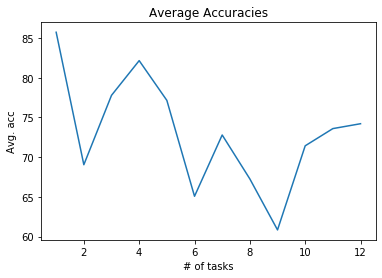

In [0]:
plt.xlabel("# of tasks")
plt.ylabel("Avg. acc")
plt.title("Average Accuracies")

x, y = list(avg_acc.keys()), list(avg_acc.values())
plt.plot(x, y)

plt.show()

### Without task dividing

In [0]:
net = NeuralNet()
if cuda_available:
    net = net.cuda()

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

logfile_name = "logfile_training_%d_%d_%d_%d_%d.txt" % (dt.year, dt.month, dt.day, dt.hour, dt.minute)
log_file = open(logfile_name, "w")

running_loss = 0
avg_acc = {}

for epoch in range(epochs):
    for key, _ in category.items():
        _train_data = train_data[key].view(9, 1, 128, 128)

        optimizer.zero_grad()
        outputs = net(_train_data)
        loss = criterion(outputs, train_labels[key])
    
        loss.backward()
        optimizer.step()
    
        running_loss += loss.data.item()

    if epoch % 5 == 4:
        msg = '[%d\t%d] AVG. loss: %.3f\n'% (task+1, epoch + 1, running_loss)
        print(msg)
        log_file.write(msg)
        running_loss = 0

each_task_acc = np.array([])
for j in range(task+1):
    total = 0
    correct = 0
    for key, _ in category.items():
        _test_data = test_data[j, key].view(3, 1, 128, 128)
        output = net(_test_data)
        _, predicted = torch.max(output.data, dim=1)
        
        total += test_labels[key].shape[0]
        correct += (predicted == test_labels[key]).sum()

    each_task_acc = np.hstack((each_task_acc, np.array([correct.cpu().numpy()*100/total])))
        
print(each_task_acc)
msg = 'Average accuracy after training task %d: %d %%\n' % (task+1, np.mean(each_task_acc))
print(msg)
log_file.write(msg)
avg_acc[task+1] = np.mean(each_task_acc)
    
log_file.close()